In [1]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
import json
import nltk
import unicodedata
import re
import string
import joblib as joblib
import pickle as pickle

In [2]:
# Load data
data_train = pd.read_csv('../Dataset/train_data.csv')
data_test = pd.read_csv('../Dataset/test_data.csv')

In [3]:
X_train = data_train['article']
y_train = data_train['label']

X_test = data_test['article']
y_test = data_test['label']

In [4]:
# Text preprocessing
def wordopt(text):
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W", " ", text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

ps = PorterStemmer()
with open('../Resources/stopwords-tl.json', 'r') as f:
    stopwords = json.load(f)

def preprocess(text):
    text = wordopt(text)
    tokens = nltk.word_tokenize(text)
    stems = [ps.stem(token) for token in tokens]
    filtered = [stem for stem in stems if stem not in stopwords]
    return filtered

In [5]:
# Apply preprocess function to X_train
X_train = X_train.apply(preprocess)

# Apply preprocess function to X_test
X_test = X_test.apply(preprocess)

In [6]:
# Convert the preprocessed text into a list of strings
X_train_processed = [' '.join(tokens) for tokens in X_train]
X_test_processed = [' '.join(tokens) for tokens in X_test]

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_processed)

# Transform the validation data using the same vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test_processed)

# Print the shape of the TF-IDF matrices (No of rows, No of columns)
print("Shape of X_train_tfidf:", X_train_tfidf.shape)
print("Shape of X_test_tfidf:", X_test_tfidf.shape)

Shape of X_train_tfidf: (2103, 27707)
Shape of X_test_tfidf: (902, 27707)


In [7]:
# Save the TfidfVectorizer using joblib
joblib.dump(tfidf_vectorizer, '../Models/Vectorizer/vectorizer_mlp.joblib')

['../Models/Vectorizer/vectorizer_mlp.joblib']

In [8]:
# Initializing base models

mnb = MultinomialNB()
lr = LogisticRegression()
rf = RandomForestClassifier()
knn = KNeighborsClassifier()
svm = SVC(probability=True)

base_models = [mnb, lr, rf, knn, svm]
base_names = ['MNB', 'LR', 'RF', 'KNN', 'SVM']

In [9]:
# Define the MLP as meta learner
mlp = MLPClassifier()

# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(10,), (20,), (50,), ], #(10,), (20,), (50,), 
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
}

# Define the GridSearchCV
mlp_grid = GridSearchCV(estimator=mlp, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

In [10]:
mlp_grid.fit(X_train_tfidf, y_train)

c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
8 fits failed out of a total of 405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ADMIN\AppData

GridSearchCV(cv=5, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh', 'logistic'],
                         'hidden_layer_sizes': [(10,), (20,), (50,)],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive'],
                         'solver': ['adam', 'sgd', 'lbfgs']},
             scoring='accuracy')

In [11]:
print("Best Hyperparameters: ", mlp_grid.best_params_)
print("Best Accuracy: {:.2f}%".format(mlp_grid.best_score_ * 100))

Best Hyperparameters:  {'activation': 'logistic', 'hidden_layer_sizes': (10,), 'learning_rate': 'invscaling', 'solver': 'lbfgs'}
Best Accuracy: 94.96%


In [12]:
# Save the mlp_grid using joblib
joblib.dump(mlp_grid, '../Models/Grid/grid_mlp.joblib')

['../Models/Grid/grid_mlp.joblib']

In [13]:
best_meta = mlp_grid.best_estimator_

In [14]:
# Create StackingClassifier
stack = StackingClassifier(estimators=list(zip(base_names, base_models)), final_estimator=best_meta, cv=5)

# Fit StackingClassifier
stack.fit(X_train_tfidf, y_train)

c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


StackingClassifier(cv=5,
                   estimators=[('MNB', MultinomialNB()),
                               ('LR', LogisticRegression()),
                               ('RF', RandomForestClassifier()),
                               ('KNN', KNeighborsClassifier()),
                               ('SVM', SVC(probability=True))],
                   final_estimator=MLPClassifier(activation='logistic',
                                                 hidden_layer_sizes=(10,),
                                                 learning_rate='invscaling',
                                                 solver='lbfgs'))

PERFORMANCE EVALUATION: TRAINING

MNB:
  Accuracy: 0.9491
  Precision: 0.9108
  Recall: 0.9962
  F1-score: 0.9516
  ROC AUC: 0.9489
  Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      1047
           1       0.91      1.00      0.95      1056

    accuracy                           0.95      2103
   macro avg       0.95      0.95      0.95      2103
weighted avg       0.95      0.95      0.95      2103

LR:
  Accuracy: 0.9767
  Precision: 0.9941
  Recall: 0.9593
  F1-score: 0.9764
  ROC AUC: 0.9768
  Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1047
           1       0.99      0.96      0.98      1056

    accuracy                           0.98      2103
   macro avg       0.98      0.98      0.98      2103
weighted avg       0.98      0.98      0.98      2103

RF:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000
  ROC AUC: 1.0000
  Cl

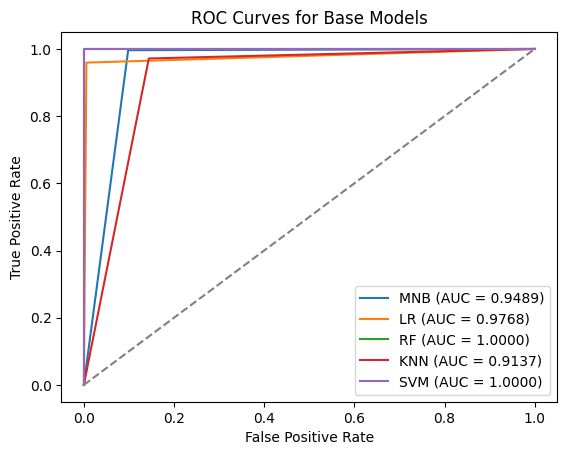

In [15]:
# Create an empty DataFrame for storing metrics
metrics_df_train = pd.DataFrame(index=base_names + ['Stacking Model'], columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])

# Access trained base models
trained_base_models = {name: model for name, model in stack.named_estimators_.items()}

# Initialize lists to store ROC curve data
plt.figure()

# Evaluate each trained base model
for name, model in trained_base_models.items():
    y_pred = model.predict(X_train_tfidf)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)
    roc_auc = roc_auc_score(y_train, y_pred)
    
    # Print evaluation metrics
    print(f"{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    
    # Store metrics in the DataFrame
    metrics_df_train.loc[name] = [accuracy, precision, recall, f1, roc_auc]
    
    # Print classification report
    print(f"  Classification Report:")
    print(classification_report(y_train, y_pred))
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_train, y_pred)

    # Plot ROC curve for each model
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

# Plot ROC curve for random guessing (baseline)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Customize plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Base Models')
plt.legend()
plt.show()

Metrics for Stacking Model:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
AUC: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1047
           1       1.00      1.00      1.00      1056

    accuracy                           1.00      2103
   macro avg       1.00      1.00      1.00      2103
weighted avg       1.00      1.00      1.00      2103



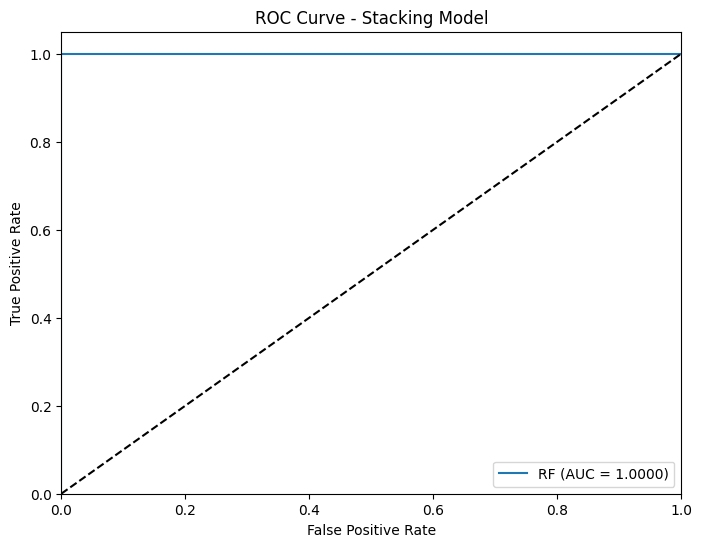

In [16]:
# Evaluate stacking model on training data
stack_y_pred_train = stack.predict(X_train_tfidf)
stack_y_prob_train = stack.predict_proba(X_train_tfidf)[:, 1]  # Probability for positive class for ROC curve

stack_accuracy_train = accuracy_score(y_train, stack_y_pred_train)
stack_precision_train = precision_score(y_train, stack_y_pred_train)
stack_recall_train = recall_score(y_train, stack_y_pred_train)
stack_f1_train = f1_score(y_train, stack_y_pred_train)
stack_auc_train = roc_auc_score(y_train, stack_y_prob_train)

print("Metrics for Stacking Model:")
print(f"Accuracy: {stack_accuracy_train:.4f}")
print(f"Precision: {stack_precision_train:.4f}")
print(f"Recall: {stack_recall_train:.4f}")
print(f"F1 Score: {stack_f1_train:.4f}")
print(f"AUC: {stack_auc_train:.4f}")
print(f"Classification Report:\n{classification_report(y_train, stack_y_pred_train)}")

# ROC Curve for stacking model
stack_fpr, stack_tpr, _ = roc_curve(y_train, stack_y_prob_train)
stack_roc_auc = roc_auc_score(y_train, stack_y_prob_train)

# Store stacking model metrics in the DataFrame
metrics_df_train.loc['Stacking Model'] = [stack_accuracy_train, stack_precision_train, stack_recall_train, stack_f1_train, stack_auc_train]

# Plot ROC Curve for stacking model
plt.figure(figsize=(8, 6))
plt.plot(stack_fpr, stack_tpr, label=f'RF (AUC = {stack_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking Model')
plt.legend(loc="lower right")
plt.show()

In [17]:
# Display the comparison table
print("Comparison of Models:")
print(metrics_df_train)

Comparison of Models:
                Accuracy Precision    Recall  F1 Score       AUC
MNB              0.94912  0.910823  0.996212  0.951606  0.948918
LR                0.9767  0.994112   0.95928  0.976386  0.976775
RF                   1.0       1.0       1.0       1.0       1.0
KNN             0.913932  0.871708  0.971591  0.918943  0.913685
SVM                  1.0       1.0       1.0       1.0       1.0
Stacking Model       1.0       1.0       1.0       1.0       1.0


PERFORMANCE EVALUATION: TESTING

MNB:
  Accuracy: 0.8348
  Precision: 0.7603
  Recall: 0.9801
  F1-score: 0.8563
  ROC AUC: 0.8342
  Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.69      0.81       449
           1       0.76      0.98      0.86       453

    accuracy                           0.83       902
   macro avg       0.87      0.83      0.83       902
weighted avg       0.87      0.83      0.83       902

LR:
  Accuracy: 0.9224
  Precision: 0.9464
  Recall: 0.8962
  F1-score: 0.9206
  ROC AUC: 0.9225
  Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       449
           1       0.95      0.90      0.92       453

    accuracy                           0.92       902
   macro avg       0.92      0.92      0.92       902
weighted avg       0.92      0.92      0.92       902

RF:
  Accuracy: 0.9279
  Precision: 0.9429
  Recall: 0.9117
  F1-score: 0.9270
  ROC AUC: 0.9280
  Cl

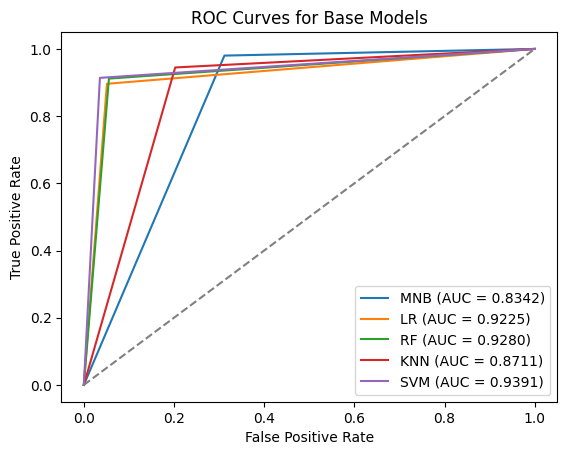

In [18]:
# Create an empty DataFrame for storing metrics
metrics_df = pd.DataFrame(index=base_names + ['Stacking Model'], columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])

# Access trained base models
trained_base_models = {name: model for name, model in stack.named_estimators_.items()}

# Initialize lists to store ROC curve data
plt.figure()

# Evaluate each trained base model
for name, model in trained_base_models.items():
    y_pred = model.predict(X_test_tfidf)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    # Print evaluation metrics
    print(f"{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    
    # Store metrics in the DataFrame
    metrics_df.loc[name] = [accuracy, precision, recall, f1, roc_auc]
    
    # Print classification report
    print(f"  Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)

    # Plot ROC curve for each model
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

# Plot ROC curve for random guessing (baseline)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Customize plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Base Models')
plt.legend()
plt.show()

Metrics for Stacking Model:
Accuracy: 0.9523
Precision: 0.9418
Recall: 0.9647
F1 Score: 0.9531079607415486:.4f
AUC: 0.9885
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       449
           1       0.94      0.96      0.95       453

    accuracy                           0.95       902
   macro avg       0.95      0.95      0.95       902
weighted avg       0.95      0.95      0.95       902



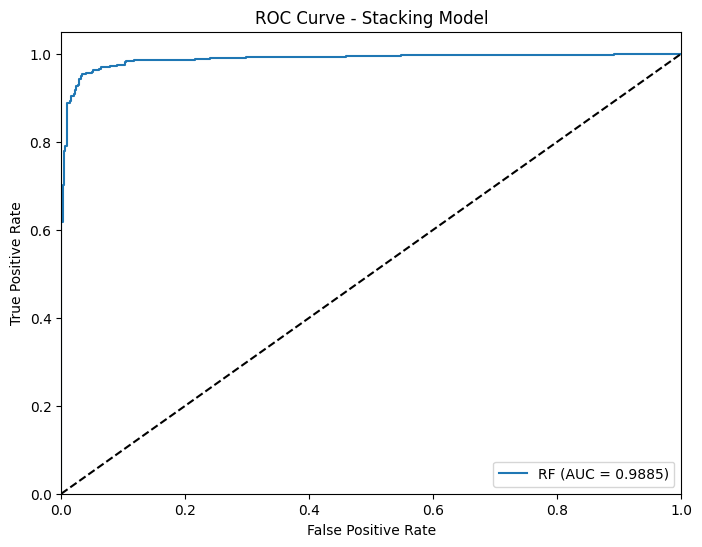

In [19]:
# Evaluate stacking model
stack_y_pred = stack.predict(X_test_tfidf)
stack_y_prob = stack.predict_proba(X_test_tfidf)[:, 1]  # Probability for positive class for ROC curve

stack_accuracy = accuracy_score(y_test, stack_y_pred)
stack_precision = precision_score(y_test, stack_y_pred)
stack_recall = recall_score(y_test, stack_y_pred)
stack_f1 = f1_score(y_test, stack_y_pred)
stack_auc = roc_auc_score(y_test, stack_y_prob)

print("Metrics for Stacking Model:")
print(f"Accuracy: {stack_accuracy:.4f}")
print(f"Precision: {stack_precision:.4f}")
print(f"Recall: {stack_recall:.4f}")
print(f"F1 Score: {stack_f1}:.4f")
print(f"AUC: {stack_auc:.4f}")
print(f"Classification Report:\n{classification_report(y_test, stack_y_pred)}")

# ROC Curve for stacking model
stack_fpr, stack_tpr, _ = roc_curve(y_test, stack_y_prob)
stack_roc_auc = roc_auc_score(y_test, stack_y_prob)

# Store stacking model metrics in the DataFrame
metrics_df.loc['Stacking Model'] = [stack_accuracy, stack_precision, stack_recall, stack_f1, stack_auc]


# Plot ROC Curve for stacking model
plt.figure(figsize=(8, 6))
plt.plot(stack_fpr, stack_tpr, label=f'RF (AUC = {stack_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking Model')
plt.legend(loc="lower right")
plt.show()

In [20]:
# Display the comparison table
print("Comparison of Models:")
print(metrics_df)

Comparison of Models:
                Accuracy Precision    Recall  F1 Score       AUC
MNB             0.834812  0.760274  0.980132  0.856316  0.834164
LR              0.922395  0.946387  0.896247  0.920635  0.922511
RF              0.927938  0.942922    0.9117  0.927048   0.92801
KNN             0.871397  0.824663  0.944812  0.880658   0.87107
SVM             0.939024  0.962791  0.913907  0.937712  0.939136
Stacking Model  0.952328   0.94181   0.96468  0.953108  0.988466


In [21]:
# Save the model using joblib
joblib.dump(stack, '../Models/Stack/stack_mlp.joblib')

['../Models/Stack/stack_mlp.joblib']